In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml/bin/python
/home/ata/miniconda3/envs/ml/bin/jupyter


In [2]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
%matplotlib widget

In [3]:
# Initialize Binance client with your API credentials
dotenv_path = Path('.env-secret')
load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client
binance_client = BinanceClient(api_key, api_secret)


#### Fetch pair data

In [4]:
fetch_data_from_binance = False
# Define trading pair and date range
pair = "BTCUSDT"
start_date = "01 Jan, 2024"
end_date = "01 Dec, 2024"


if fetch_data_from_binance:
    # Fetch data
    data = binance_client.fetch_data(pair, start_date, end_date)
    binance_client.store_data_to_db(pair, data)
else:
    data = binance_client.fetch_data_from_db(pair, start_date, end_date)

  # Check if data is fetched
if not data.empty:
    # Convert the fetched data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Set the timestamp as the index
    df.set_index('timestamp', inplace=True)
    
    # Convert the columns to numeric (some values may be strings by default)
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric)
else:
    print("No data found!!!.")  

#### Define target 

In [17]:
# Predict the price change over the next 'n' candles
nn = 12
df['target'] = (df['close'].shift(nn) - df['close']) / df['close'] * 100

#### Feature engineering

In [6]:
# Simple Moving Average (SMA)
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Average (EMA)
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Volatility Indicators

# Bollinger Bands
sma_20 = df['close'].rolling(window=20).mean()
std_20 = df['close'].rolling(window=20).std()
df['bollinger_upper'] = sma_20 + (2 * std_20)
df['bollinger_lower'] = sma_20 - (2 * std_20)

# Average True Range (ATR)
high_low = df['high'] - df['low']
high_prev_close = (df['high'] - df['close'].shift()).abs()
low_prev_close = (df['low'] - df['close'].shift()).abs()
true_range = high_low.to_frame('hl').join(high_prev_close.to_frame('hpc')).join(low_prev_close.to_frame('lpc')).max(axis=1)
df['atr_14'] = true_range.rolling(window=14).mean()

# Volume-Based Features
df['volume_ma_20'] = df['volume'].rolling(window=20).mean()
df['volume_ratio'] = df['volume'] / df['volume_ma_20']

# Derived Features

# Rate of Change (ROC)
df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10) * 100

# Lagged Features
df['close_lag_1'] = df['close'].shift(1)
df['close_lag_3'] = df['close'].shift(3)
df['macd_lag_1'] = df['close'].shift(1)

# Candle Features
df['candle_body'] = df['close'] - df['open']
df['upper_wick'] = df['high'] - df[['close', 'open']].max(axis=1)
df['lower_wick'] = df[['close', 'open']].min(axis=1) - df['low']

In [ ]:
df.head()

In [30]:
df.dropna(inplace=True)

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

#### Test/Train Split

In [36]:
# df is sorted by time and indexed by a datetime index
n = len(df)
train_end = int(n * 0.8) # 80% data used for training
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# Separate features and target
X_train = train_df.drop(['target', 'close'], axis=1)
y_train = train_df['target']

X_test = test_df.drop(['target', 'close'], axis=1)
y_test = test_df['target']


In [12]:
import cupy as cp
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)


ModuleNotFoundError: No module named 'cupy'

#### Grid Search for Hyperparameter Tuning 

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# # Define the model with GPU support
# xgb_reg = XGBRegressor(tree_method='hist', device='cuda')

# # Define your model and pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Scaling step
#     ('regressor', xgb_reg)  # Model
# ])
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
# }


# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train, y_train)


#### Save GridSearch Results

In [93]:
import joblib

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_results.pkl')

['grid_search_results.pkl']

#### Load saves GridSearch results

In [12]:
import joblib

# Load GridSearch results
grid_search = joblib.load('grid_search_results.pkl')


#### Analyse grid search results

In [13]:

# Access best parameters or results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__max_features': 10, 'regressor__n_estimators': 100}
Best Score: -0.03582902265400254


In [14]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

Best Parameters: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__max_features': 10, 'regressor__n_estimators': 100}


In [22]:
cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    # print(np.sqrt(-mean_score), params)

#### Best Model Training

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Extract best parameters from GridSearchCV
best_params = grid_search.best_params_

# Remove 'regressor__' prefix to pass parameters directly to the model
model_params = {key.replace('regressor__', ''): value for key, value in best_params.items()}

# Train the model using the best parameters
best_model = RandomForestRegressor(**model_params)

# NOTE: Feature scaling is not requiredfor Random Forest regressor
best_model.fit(X_train, y_train)

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importance_df.head(10))

         Feature  Importance
16        roc_10    0.453052
7         rsi_14    0.213836
10     macd_hist    0.170203
8           macd    0.082735
3         volume    0.020863
13        atr_14    0.020541
9    macd_signal    0.016503
14  volume_ma_20    0.007095
20   candle_body    0.003646
15  volume_ratio    0.001498


#### Best Model Prediction

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


Mean Squared Error (MSE): 0.02477963820292541
Mean Absolute Error (MAE): 0.10868881349023932
R² Score: 0.8984431105403718


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", alpha=0.8)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Percentage Change")
plt.show()


#### Trading Signal Generation

In [68]:
# Define thresholds
buy_threshold = -0.5  # Buy when predicted change is below this
sell_threshold = 0.5  # Sell when predicted change is above this

# Use the model's predictions
predictions = best_model.predict(X_test)  # Predicted percentage changes

# Generate signals with reversed logic
trading_signals = [
    "Buy" if pred < buy_threshold else "Sell" if pred > sell_threshold else "Hold"
    for pred in predictions
]

# Add signals to a DataFrame for analysis
results_df = X_test.copy()
results_df['Predicted Change'] = predictions
results_df['Signal'] = trading_signals

# Print the updated signals
# print(results_df.head())


#### Beck Testing

In [133]:
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
position = 0  # No stock initially
trading_log = []  # To store completed trades

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
results_df['open'] = df.loc[results_df.index, 'open']
results_df['close'] = df.loc[results_df.index, 'close']

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['open']  # Use 'open' price for Buy
    volume = balance / price if signal == "Buy" and balance > 0 else position  # Calculate volume

    if signal == "Buy" and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = volume
        position = volume  # Update position
        balance = 0  # All money is invested

    elif signal == "Sell" and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = row['close']  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Sell Volume": buy_volume,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['close']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Sell Volume": buy_volume,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - initial_balance:.2f}")

# Print the trading log
# print(trading_log_df)
# trading_log_df.head()


Final Balance: $16354.23
Net Profit: $6354.23


#### Compute Baseline

In [135]:
# Initial setup
initial_balance = 10000  # Starting with $10,000

# Get starting and ending prices
initial_price = results_df.iloc[0]['close']  # Opening price at the first date
final_price = results_df.iloc[-1]['close']  # Closing price at the last date

# Calculate number of shares purchased with initial balance
shares = initial_balance / initial_price

# Calculate final balance
final_balance_baseline = shares * final_price

# Calculate profit/loss for the baseline strategy
profit_loss_baseline = final_balance_baseline - initial_balance

# Print results
print(f"Baseline Final Balance: ${final_balance_baseline:.2f}")
print(f"Baseline Strategy Profit/Loss: ${profit_loss_baseline:.2f}")


Baseline Final Balance: $15086.91
Baseline Strategy Profit/Loss: $5086.91


#### Baseline Comparison

In [136]:
# Assuming `profit_loss_estimator` is calculated from your trading log
profit_loss_estimator = trading_log_df['Profit/Loss'].sum()

# Calculate difference and percentage improvement
difference = profit_loss_estimator - profit_loss_baseline
improvement_percentage = (difference / abs(profit_loss_baseline)) * 100 if profit_loss_baseline != 0 else None

# Print comparison
print(f"Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Difference vs. Baseline: ${difference:.2f}")
if improvement_percentage is not None:
    print(f"Performance Improvement: {improvement_percentage:.2f}%")
else:
    print("Baseline profit/loss is zero, percentage improvement cannot be calculated.")


Estimator Profit/Loss: $6354.23
Difference vs. Baseline: $1267.32
Performance Improvement: 24.91%


In [148]:
# Ensure 'Buy Date' and 'Sell Date' are datetime
trading_log_df['Buy Date'] = pd.to_datetime(trading_log_df['Buy Date'])
trading_log_df['Sell Date'] = pd.to_datetime(trading_log_df['Sell Date'])

# Add a 'Sell Date (Day)' column for aggregation
trading_log_df['Sell Date (Day)'] = trading_log_df['Sell Date'].dt.date

# Aggregate profit/loss by day
daily_returns_df = trading_log_df.groupby('Sell Date (Day)')['Profit/Loss'].sum().reset_index()
daily_returns_df.rename(columns={'Profit/Loss': 'Daily Profit/Loss'}, inplace=True)

# Calculate daily returns as a percentage of the initial balance
daily_returns_df['Daily Return'] = daily_returns_df['Daily Profit/Loss'] / initial_balance

# Calculate average and standard deviation of daily returns
average_daily_return = daily_returns_df['Daily Return'].mean()
std_dev_daily_return = daily_returns_df['Daily Return'].std()

# Compute Sharpe Ratio
risk_free_rate = 0  # Assuming no risk-free rate for simplicity
sharpe_ratio_estimator = (average_daily_return - risk_free_rate) / std_dev_daily_return

print(f"Sharpe Ratio (Estimator): {sharpe_ratio_estimator:.2f}")




# Total duration of the baseline strategy (in days)
total_days = (results_df.index[-1] - results_df.index[0]).days

# Baseline return: Profit/Loss normalized by initial balance
baseline_return = (final_price - initial_price) / initial_price

# Average daily return for the baseline
baseline_average_daily_return = baseline_return / total_days

# Standard deviation of daily returns for baseline (set a small epsilon if zero)
baseline_std_dev_daily_return = max(np.std([baseline_return]), 1e-8)  # Avoid division by zero

# Compute Sharpe Ratio for baseline
sharpe_ratio_baseline = baseline_average_daily_return / baseline_std_dev_daily_return

# Print results
print(f"Baseline Return: {baseline_return * 100:.2f}%")
print(f"Baseline Average Daily Return: {baseline_average_daily_return * 100:.4f}%")
print(f"Baseline Sharpe Ratio: {sharpe_ratio_baseline}")



Sharpe Ratio (Estimator): 0.39
Baseline Return: 50.87%
Baseline Average Daily Return: 0.7707%
Baseline Sharpe Ratio: 770744.1271372216


In [141]:
# Calculate momentum (percentage change in price)
momentum_threshold = 0.01  # 1% change as momentum threshold
momentum_signals = results_df['close'].pct_change()  # Calculate percentage change
momentum_trades = momentum_signals[momentum_signals.abs() > momentum_threshold]

# Initialize profit/loss calculation for momentum strategy
momentum_profit_loss = 0
balance = initial_balance
position = 0

# Iterate through momentum trades
for idx, change in momentum_trades.items():  # Use .items() for Series iteration
    price = results_df.loc[idx, 'close']
    if change > 0 and balance > 0:  # Buy signal
        position = balance / price
        balance = 0
    elif change < 0 and position > 0:  # Sell signal
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

momentum_profit_loss = balance - initial_balance

print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")


Momentum Strategy Profit/Loss: $3364.80


In [144]:
rolling_window = 20
results_df['SMA'] = results_df['close'].rolling(rolling_window).mean()
results_df['Deviation'] = results_df['close'] - results_df['SMA']

# Drop NaN rows to avoid issues with rolling mean
mean_reversion_trades = results_df.dropna()

# Generate signals explicitly with .loc
mean_reversion_trades.loc[:, 'Signal'] = mean_reversion_trades['Deviation'].apply(
    lambda x: 'Buy' if x < 0 else 'Sell'
)

# Simulate mean-reversion trading
balance = initial_balance
position = 0
mean_reversion_profit_loss = 0

for idx, row in mean_reversion_trades.iterrows():
    price = row['close']
    signal = row['Signal']
    if signal == 'Buy' and balance > 0:  # Buy
        position = balance / price
        balance = 0
    elif signal == 'Sell' and position > 0:  # Sell
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

mean_reversion_profit_loss = balance - initial_balance

print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")


Mean-Reversion Strategy Profit/Loss: $2099.77


In [149]:
print(f"Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Baseline Profit/Loss: ${profit_loss_baseline:.2f}")
print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")
print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")
print(f"Sharpe Ratio (Estimator): {sharpe_ratio_estimator:.2f}")
print(f"Sharpe Ratio (Baseline): {sharpe_ratio_baseline:.2f}")


Estimator Profit/Loss: $6354.23
Baseline Profit/Loss: $5086.91
Momentum Strategy Profit/Loss: $3364.80
Mean-Reversion Strategy Profit/Loss: $2099.77
Sharpe Ratio (Estimator): 0.39
Sharpe Ratio (Baseline): 770744.13


#### Visualizations

In [ ]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Price'], label='Predicted Price', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Price'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Price'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.8
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.8
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


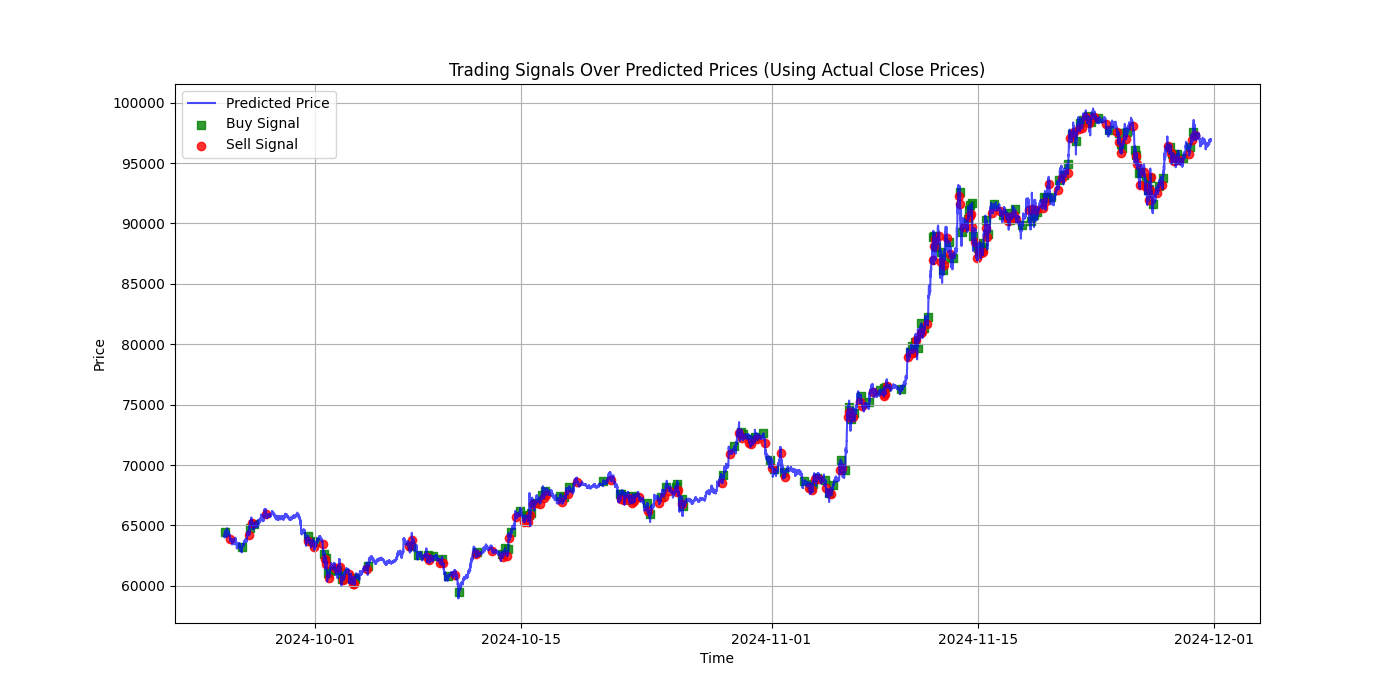

In [105]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['close'], label='Predicted Price', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'close'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'close'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.8
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.8
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df (if not already added)
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['close'], label='Actual Close', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Add vertical lines for Buy signals
for _, row in buy_signals.iterrows():
    plt.axvline(
        x=row['Buy Date'], 
        color='green', 
        linestyle='--', 
        linewidth=2,  # Increased line thickness
        label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "", 
        alpha=0.25
    )

# Add vertical lines for Sell signals
for _, row in sell_signals.iterrows():
    plt.axvline(
        x=row['Sell Date'], 
        color='red', 
        linestyle='-', 
        linewidth=2,  # Increased line thickness
        label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "", 
        alpha=0.25
    )

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Vertical Lines)")
plt.xlabel("Time")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.show()
